In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

# 전이학습
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input, decode_predictions

In [ ]:
caltech_dir = "/content/drive/MyDrive/Colab Notebooks/gender_classification/dataset/train"
categories = ["man", "woman"]
num_classes = len(categories)

image_w = 128
image_h = 128

pixels = image_h * image_w * 3

X = []
y = []

for idx, category in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(num_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + category
    files = glob.glob(image_dir+"/*.jpg")
    print(category, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(category, " : ", f)

X = np.array(X)
y = np.array(y)
#1 0  이면 man
#0 1  이면 woman 이런식


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("/content/drive/MyDrive/Colab Notebooks/gender_classification/dataset/gender_data1.npy", xy)

print("ok", len(y))

In [4]:
X_train, X_test, y_train, y_test = np.load('/content/drive/MyDrive/Colab Notebooks/gender_classification/dataset/gender_data1.npy', allow_pickle = True) 

In [5]:
categories = ["man", "woman"]
num_classes = len(categories)

#일반화
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [6]:
X_train.shape

(1408, 128, 128, 3)

In [7]:
model = ResNet50V2(include_top=True, weights=None, input_shape=(128, 128, 3), classes=2)

In [8]:
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [9]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [10]:
history = model.fit(X_train, y_train, 
                    batch_size = 64, 
                    epochs = 50, 
                    verbose = 1,
                    validation_data=(X_test, y_test))

Epoch 1/50
22/22 [==============================] - 43s 281ms/step - loss: 0.9269 - accuracy: 0.6101 - val_loss: 0.7011 - val_accuracy: 0.4617
Epoch 2/50
22/22 [==============================] - 5s 215ms/step - loss: 0.4287 - accuracy: 0.8111 - val_loss: 0.7456 - val_accuracy: 0.5234
Epoch 3/50
22/22 [==============================] - 5s 218ms/step - loss: 0.2868 - accuracy: 0.8807 - val_loss: 0.6729 - val_accuracy: 0.5809
Epoch 4/50
22/22 [==============================] - 5s 218ms/step - loss: 0.2326 - accuracy: 0.8984 - val_loss: 1.4151 - val_accuracy: 0.5213
Epoch 5/50
22/22 [==============================] - 5s 218ms/step - loss: 0.2459 - accuracy: 0.9070 - val_loss: 0.8592 - val_accuracy: 0.6106
Epoch 6/50
22/22 [==============================] - 5s 227ms/step - loss: 0.1344 - accuracy: 0.9496 - val_loss: 0.6881 - val_accuracy: 0.6532
Epoch 7/50
22/22 [==============================] - 5s 219ms/step - loss: 0.0639 - accuracy: 0.9787 - val_loss: 0.6416 - val_accuracy: 0.7617
Epoch

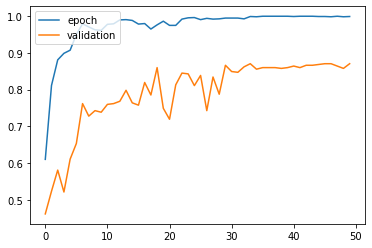

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['epoch', 'validation'], loc = 'upper left')
plt.show()

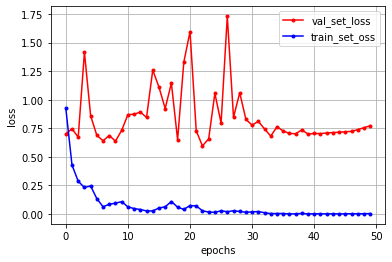

In [12]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [13]:
# predict 메서드로 테스트 세트에 대한 예측 결과 확인

CLASSES = np.array(['Man', 'Woman'])

preds = model.predict(X_test) 
preds_single = CLASSES[np.argmax(preds, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

In [14]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 1s 36ms/step - loss: 0.7721 - accuracy: 0.8702


[0.772089421749115, 0.8702127933502197]

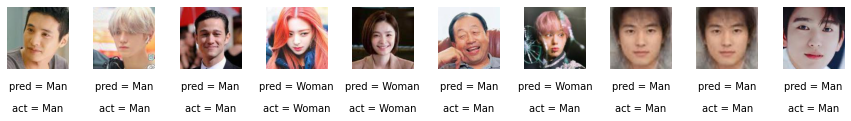

In [15]:
n_to_show = 10
indices = np.random.choice(range(len(X_test)), n_to_show)

fig = plt.figure(figsize = (15, 3))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

for i, idx in enumerate(indices):
  img = X_test[idx] 
  ax = fig.add_subplot(1, n_to_show, i+1)
  ax.axis('off')
  ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize = 10, ha = 'center', transform = ax.transAxes)
  ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize = 10, ha = 'center', transform = ax.transAxes)
  ax.imshow(img)